# Derived from https://tensorflow.keras.io/examples/imdb_cnn/

In [0]:
import tensorflow as tf
from __future__ import print_function

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.datasets import imdb

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.utils import plot_model
import IPython
import numpy as np

In [0]:
# set parameters:
max_features = 5000
maxlen = 400
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 8

special = { "<PAD>": 0, 
           "<START>": 1,
           "<UNK>": 2
           }

In [105]:
print('Loading data...')
# start_char == 1: start of sequence character is encoded with integer 1
# oov_char   == 2: Out of Vocabulary word is encoded with integer 2
# index_from == 3: The first word (i.e, most frequent) in the vocabulary is encoded with integer 3
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features,
                                                      start_char=special["<START>"],
                                                      oov_char=special["<UNK>"],
                                                      index_from=3
                                                      )
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)



Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 400)
x_test shape: (25000, 400)


# Examine the text data

In [106]:

# See https://stackoverflow.com/questions/42821330/restore-original-text-from-keras-s-imdb-dataset
# word_index: maps words to rank in vocabulary (0 is most frequent)
word_index = imdb.get_word_index()

# Create word to index map
# load_data has assigned indexes 0, 1, 2 to (<PAD>, <START>, <UNK>) so load_data assigns the rank 0 word to index 3
word_index = { w:(k+3) for w,k in word_index.items() }

# Add the special characters to the word to index map
for word, idx in special.items():
  word_index[word] = idx

# Reverse map: index to word
index_word = { idx:w for (w, idx) in word_index.items() }

sentiment = { 0: "negative", 1: "positive"}

for i, rev in enumerate(x_train[0:5]):
  # Map index back to word
  rev_words = [ index_word[idx] for idx in rev if idx != 0]

  sent = y_train[i]
  print("{i:d}: ({sent:s})\t{r:s}".format(i=i, sent=sentiment[y_train[i]], r= " ".join(rev_words)) )

0: (positive)	<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly <UNK> was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little <UNK> that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big <UNK> for the whole film but these children are amazing and should be <UNK>

# Utility functions

In [0]:
def plotModel(model, modelName):
  plotFile = modelName + ".png"
  plot_model(model, plotFile, show_shapes=True)

  return plotFile

In [0]:


def createModel(doConv=True, learn_embeddings=True):
  model = Sequential()

  # we start off with an efficient embedding layer which maps
  # our vocab indices into embedding_dims dimensions
  if learn_embeddings:
    # Word embeddings are trainable and small size (embedding_dims) vectors
    model.add(Embedding(max_features,
                      embedding_dims,
                      input_length=maxlen))
  else:
    # "Embeddings" are simply One Hot Encoding of the vocabulary
    # - word embeddings are NOT trainable and LARGE size (length of vocabulary) vectors
    weights_OHE= createOHE()
    embedding_dims_OHE = weights_OHE.shape[-1]

    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    model.add(Embedding(max_features,
                      embedding_dims_OHE,
                      input_length=maxlen,
                      weights=[weights_OHE],
                      trainable=False
                     )
         )
    
  model.add(Dropout(0.2))

  if doConv:
    # we add a Convolution1D, which will learn filters
    # word group filters of size filter_length:
    model.add(Conv1D(filters,
                    kernel_size,
                    padding='valid',
                    activation='relu',
                    strides=1))
    
  # we use max pooling:
  model.add(GlobalMaxPooling1D())

  # We add a vanilla hidden layer:
  model.add(Dense(hidden_dims))
  model.add(Dropout(0.2))
  model.add(Activation('relu'))

  # We project onto a single unit output layer, and squash it with a sigmoid:
  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  return model

def trainModel(model):
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  
  es_callback = EarlyStopping(monitor='val_loss', min_delta=.005, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

  callbacks = [ es_callback,
                    # ModelCheckpoint(filepath=modelName + ".ckpt", monitor='acc', save_best_only=True)
                ] 

  history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_test, y_test),
            callbacks=callbacks)
  
  return history

def createOHE():
  mat = np.diag( np.ones(max_features))
  return mat



# Simple model
- OHE
- GlobalMaxPooling1D to convert from variable length to fixed length

In [109]:
model_ohe = createModel(learn_embeddings=False, doConv=False)
model.summary()



Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 400, 50)           250000    
_________________________________________________________________
dropout_20 (Dropout)         (None, 400, 50)           0         
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 50)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 250)               12750     
_________________________________________________________________
dropout_21 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_20 (Activation)   (None, 250)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

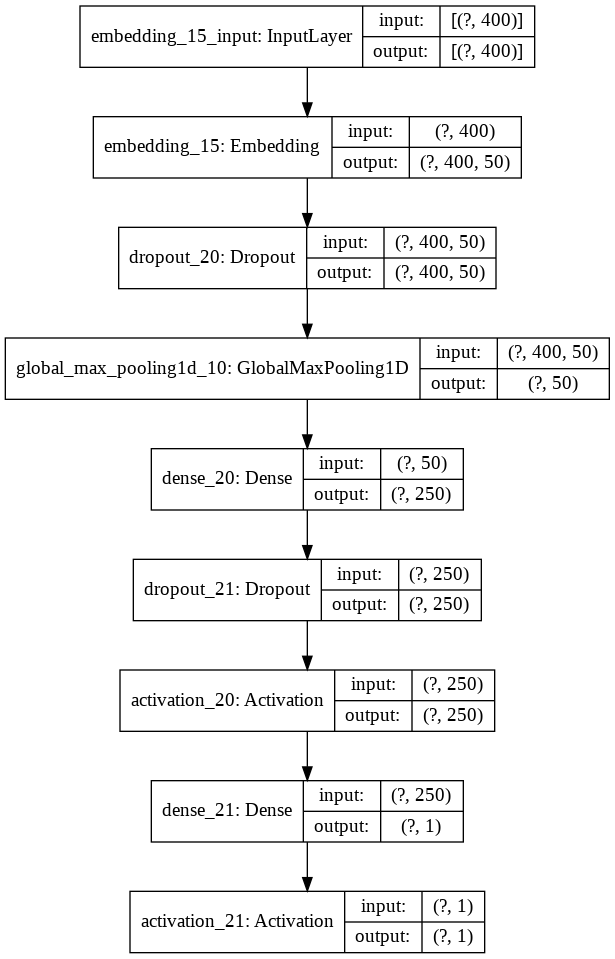

In [110]:
plotFile = plotModel(model, "imbdb_OHE_noconv")
IPython.display.Image(plotFile) 

In [111]:
history_ohe = trainModel(model_ohe)

Train on 25000 samples, validate on 25000 samples
Epoch 1/8
25000/25000 [==============================] - 38s 2ms/sample - loss: 0.3529 - acc: 0.8464 - val_loss: 0.3018 - val_acc: 0.8727
Epoch 2/8
25000/25000 [==============================] - 38s 2ms/sample - loss: 0.2464 - acc: 0.8974 - val_loss: 0.2971 - val_acc: 0.8725
Epoch 3/8
25000/25000 [==============================] - 38s 2ms/sample - loss: 0.2009 - acc: 0.9195 - val_loss: 0.3003 - val_acc: 0.8717


## Note: the test data set was used as the validation_data in the fit method above
- so nothing really to see here


In [112]:
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

25000/25000 [==============================] - 2s 70us/sample - loss: 0.3047 - acc: 0.8691
Test score: 0.30465209916114805
Test accuracy: 0.86908


In [113]:
print("OHE Embeddings (first few):")
embeddings_ohe = model_ohe.layers[0].get_weights()[0]
embeddings_ohe[:4,:7]

OHE Embeddings (first few):


array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

# Model with learned embeddings
- learn low-dimensional word embeddings


In [114]:
model_emb = createModel(doConv=False)
model_emb.summary()


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 400, 50)           250000    
_________________________________________________________________
dropout_32 (Dropout)         (None, 400, 50)           0         
_________________________________________________________________
global_max_pooling1d_16 (Glo (None, 50)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 250)               12750     
_________________________________________________________________
dropout_33 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_32 (Activation)   (None, 250)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)               

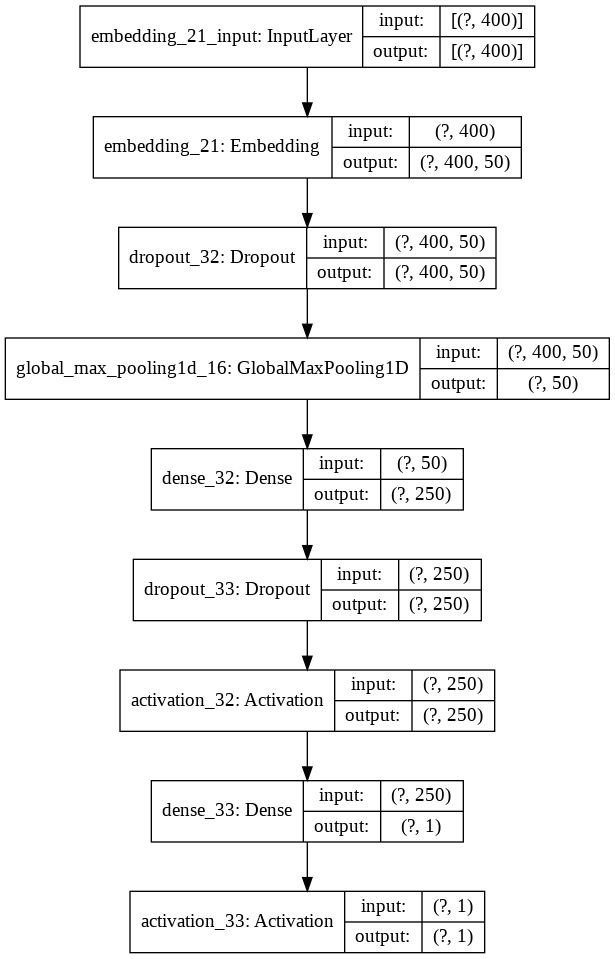

In [115]:
plotFile = plotModel(model_emb, "imbdb_emb")
IPython.display.Image(plotFile) 

In [116]:
history_emb=trainModel(model_emb)

Train on 25000 samples, validate on 25000 samples
Epoch 1/8
25000/25000 [==============================] - 7s 294us/sample - loss: 0.4279 - acc: 0.7937 - val_loss: 0.3180 - val_acc: 0.8658
Epoch 2/8
25000/25000 [==============================] - 7s 262us/sample - loss: 0.2804 - acc: 0.8842 - val_loss: 0.3088 - val_acc: 0.8692
Epoch 3/8
25000/25000 [==============================] - 7s 265us/sample - loss: 0.2440 - acc: 0.8978 - val_loss: 0.3129 - val_acc: 0.8644
Epoch 4/8
25000/25000 [==============================] - 7s 280us/sample - loss: 0.2183 - acc: 0.9106 - val_loss: 0.3221 - val_acc: 0.8608


# Model with learned embeddings, n-grams (phrases)
- conv1d to learn n-grams

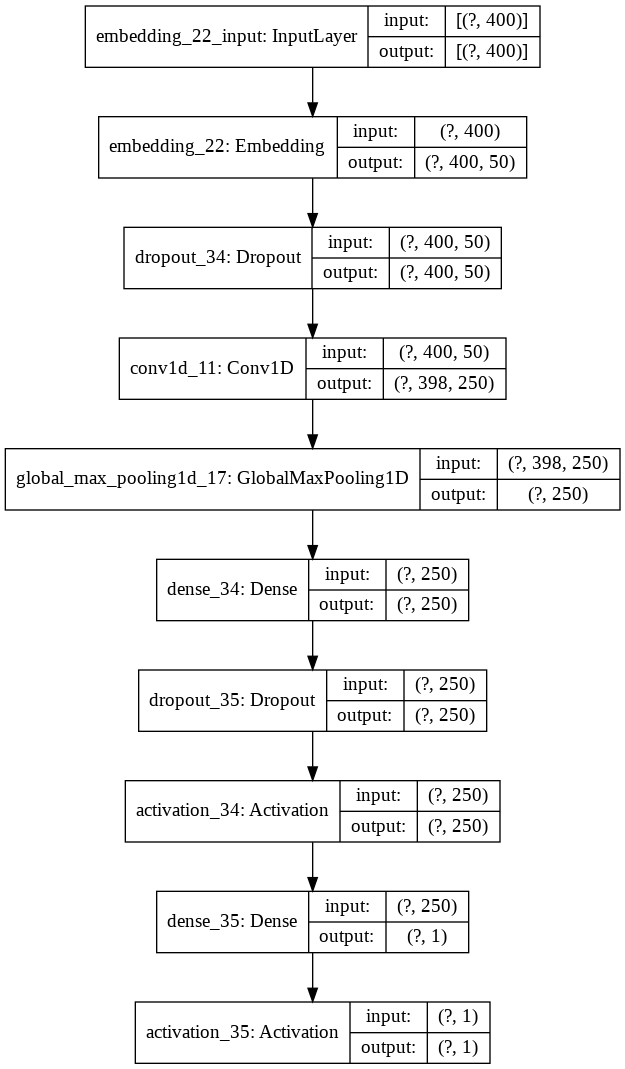

In [117]:
model_emb_ngram = createModel(doConv=True)
plotFile = plotModel(model_emb_ngram, "imbdb_emb_ngram")
IPython.display.Image(plotFile) 

In [118]:
history_emb_ngram=trainModel(model_emb_ngram)

Train on 25000 samples, validate on 25000 samples
Epoch 1/8
25000/25000 [==============================] - 11s 451us/sample - loss: 0.4101 - acc: 0.7958 - val_loss: 0.2736 - val_acc: 0.8865
Epoch 2/8
25000/25000 [==============================] - 10s 415us/sample - loss: 0.2336 - acc: 0.9075 - val_loss: 0.2731 - val_acc: 0.8862
Epoch 3/8
25000/25000 [==============================] - 11s 429us/sample - loss: 0.1686 - acc: 0.9368 - val_loss: 0.2888 - val_acc: 0.8876
